In [121]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uber-fares-dataset/uber.csv


In [122]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("/kaggle/input/uber-fares-dataset/uber.csv")

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [124]:
# Dropping the missing values 
df = df.dropna(subset=['dropoff_longitude', 'dropoff_latitude'])

In [125]:
# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [126]:
# Extract day of the week, hour of the day, and month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month

In [127]:
# Drop the 'Unnamed: 0' and 'key' columns
df = df.drop(['Unnamed: 0', 'key'], axis=1)

In [128]:
import numpy as np

# Function to calculate haversine distance
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of Earth in kilometers
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Apply haversine distance calculation
df['distance_km'] = haversine(df['pickup_longitude'], df['pickup_latitude'],
                              df['dropoff_longitude'], df['dropoff_latitude'])


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  int64              
 7   day_of_week        199999 non-null  int32              
 8   hour_of_day        199999 non-null  int32              
 9   month              199999 non-null  int32              
 10  distance_km        199999 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int32(3), int64(1)
memory usage: 16.0 MB


In [131]:
import numpy as np

def capOutliers(df, columns):
    df_capped = df.copy()  # Create a copy of the original DataFrame

    for column in columns:
        lower_bound = df_capped[column].quantile(0.01)  # Calculate the 1st percentile
        upper_bound = df_capped[column].quantile(0.99)  # Calculate the 99th percentile
        
        # Cap the values in the column
        df_capped[column] = np.where(df_capped[column] < lower_bound, lower_bound, df_capped[column])
        df_capped[column] = np.where(df_capped[column] > upper_bound, upper_bound, df_capped[column])
    
    return df_capped

# Apply on fare_amount, passenger_count, distance_km
columns_to_cap = ["fare_amount", "passenger_count", "distance_km"]
df_cleaned = capOutliers(df, columns_to_cap)

print(f"Original data shape: {df.shape}")
print(f"Capped data shape: {df_cleaned.shape}")

Original data shape: (199999, 11)
Capped data shape: (199999, 11)


In [132]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  float64            
 7   day_of_week        199999 non-null  int32              
 8   hour_of_day        199999 non-null  int32              
 9   month              199999 non-null  int32              
 10  distance_km        199999 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7), int32(3)
memory usage: 16.0 MB


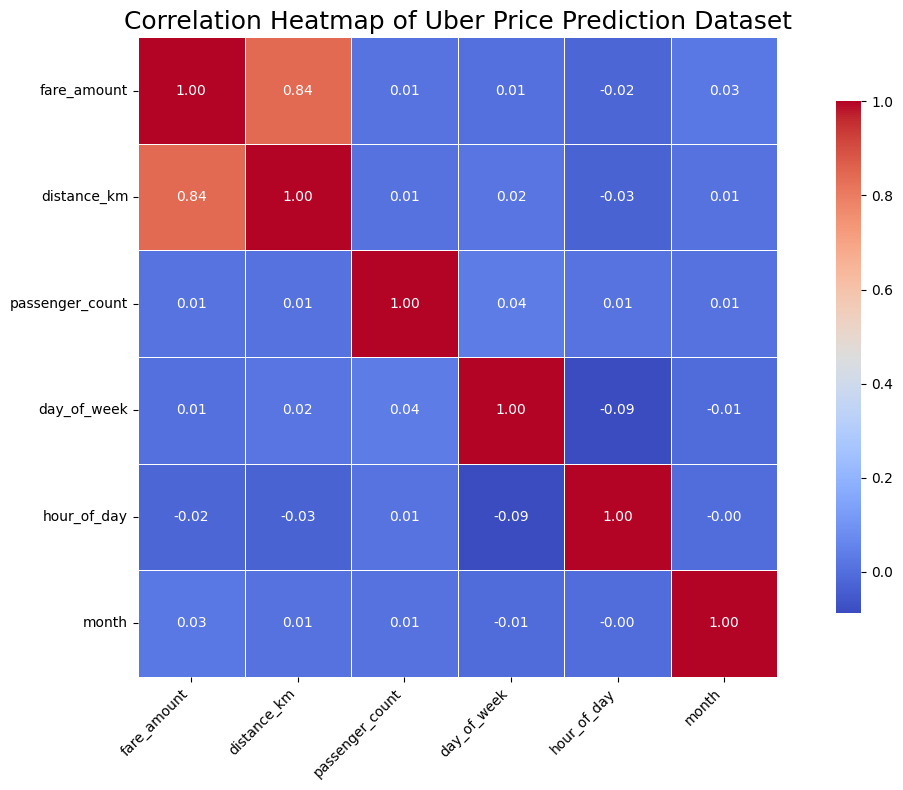

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

df_test = df_cleaned[["fare_amount",'distance_km', 'passenger_count', 'day_of_week', 'hour_of_day', 'month']]
# Calculate the correlation matrix
correlation_matrix = df_test.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, 
            annot=True,        # Show correlation coefficients
            fmt=".2f",        # Format for the annotations
            cmap="coolwarm",  # Color palette
            square=True,      # Make cells square-shaped
            linewidths=0.5,  # Lines between cells
            cbar_kws={"shrink": .8},  # Color bar shrink
            mask=None)        # Masking for upper triangle if desired

# Title and labels
plt.title('Correlation Heatmap of Uber Price Prediction Dataset', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to make room for labels

# Show the plot
plt.show()

In [134]:
from sklearn.model_selection import train_test_split

# Define your features and target variable
X = df_cleaned[['distance_km', 'passenger_count', 'day_of_week', 'hour_of_day', 'month']]
y = df_cleaned['fare_amount']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [135]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = lin_reg.predict(X_test)

In [136]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate Linear Regression
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Linear Regression RMSE: {rmse}')
print(f'Linear Regression R²: {r2}')

Linear Regression RMSE: 5.00939230453408
Linear Regression R²: 0.6945436247499934


In [137]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_reg.predict(X_test)

In [138]:
# Evaluate Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R²: {r2_rf}')

Random Forest RMSE: 4.89074794162698
Random Forest R²: 0.7088413701984508
